In [1]:
from IPython.core.display import HTML
HTML("\n".join(open("c360_style.css", 'r').readlines()))

## Libs

In [2]:
from criteo import criteoClass
criteo = criteoClass()
from ml_scikit import mlScikitClass
ml = mlScikitClass()

In C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anacon

In [3]:
import pandas as pd
import time
import numpy as np
from numpy import std, mean
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
import scikitplot as skplt
plt.style.use('ggplot')

In [113]:
from sklearn import metrics
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate, cross_val_predict, train_test_split,learning_curve 
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score

## Data load

In [5]:
df7 = pd.read_csv('df_final_c.txt', sep=';')

In [6]:
df8 = criteo.map_one_hot(df7, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df9 = criteo.map_one_hot(df8, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [7]:
X, y = criteo.features_for_modelling(df9)
print(np.shape(X))

(16657, 295)


## ML Engineering

In [9]:
balance = df9.groupby([ 'conversion']).agg({'timestamp':'count'})
balance = balance.reset_index()
balance.columns = ['conversion', 'count']
balance['conversion'] = balance['conversion'].astype(str)
balance['conversion'] = balance['conversion'].replace(['0'],'No Converted')
balance['conversion'] = balance['conversion'].replace(['1'],'Converted')
fig = px.bar(balance, x='conversion', y=['count'], title= "Preliminary assessemtn of  Dataset", width=400, height=400)
fig.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [11]:
def final_balance(y):
    class_name = ['No converted', 'Converted']
    class_split = [len(y[y==0]), len(y[y>0])]
    balanced=pd.DataFrame({'Category':class_name, 'Result':class_split}) 
    return balanced

In [12]:
def render_distribution(): 
    all_ = final_balance(y)
    train_ = final_balance(y_train)
    test_ = final_balance(y_test)
    fig = make_subplots(rows=1, cols=3, shared_yaxes=False, 
                    subplot_titles=("All dataset","Train dataset", "Test dataset"))

    fig.add_trace(go.Bar(x=all_['Category'], y=all_['Result']),
                  1, 1)

    fig.add_trace(go.Bar(x=train_['Category'], y=train_['Result']),
                  1, 2)

    fig.add_trace(go.Bar(x=test_['Category'], y=test_['Result']),
                  1, 3)

    fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
    fig.show()

In [13]:
render_distribution()

<div class="images">
  <span class="closebtn" onclick="">×</span>
  <strong>Out of scope:</strong> I go thru this shortcut this non balanced dataset would bring more complexity to the problem.
</div>

In [14]:
df = pd.DataFrame(X)
df['target'] = pd.DataFrame(y)
df1 = df.drop(df[df['target'].eq(1)].sample(4000).index)
X=df1.loc[:, df1.columns != 'target'].to_numpy()
y=df1['target'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [16]:
render_distribution()

In [101]:
def output_model(model, model_name):
    print('************************************** '+model_name+' **************************************')
    start_time = time.time()
    if model_name == 'XGBoost':
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        scores = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
        metrics='logloss', early_stopping_rounds=50)
        print('Cross Val Score time consumption: --- %s seconds ---' % (time.time() - start_time))
        print('Log Loss cross validated: %.3f (%.3f)' % (scores['test-logloss-mean'].mean(), scores['test-logloss-std'].mean()))
        y_pred = cross_val_predict(model, X_train, y_train, cv=5)
        conf_mat = confusion_matrix(y_train, y_pred)
        print('Cross Val Predict time consumption: --- %s seconds ---' % (time.time() - start_time))
        print(conf_mat)
        print('*********************************************************************************************')
        return scores, model.get_params(), y_pred, conf_mat
    else:
        scores = cross_val_score(model, X_train, y_train,  cv=5, n_jobs=-1)
        print('Cross Val Score time consumption: --- %s seconds ---' % (time.time() - start_time))
        print('Accuracy cross validated: %.3f (%.3f)' % (mean(scores), std(scores)))
        y_pred = cross_val_predict(model, X_train, y_train, cv=5)
        conf_mat = confusion_matrix(y_train, y_pred)
        print('Cross Val Predict time consumption: --- %s seconds ---' % (time.time() - start_time))
        print(conf_mat)
        print('*********************************************************************************************')
        return scores, model.get_params(), y_pred, conf_mat

In [83]:
def assess_model(confusion_matrix):
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TP = confusion_matrix[0][0]
    TN = confusion_matrix[1][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    metrics = [TPR, FNR, TNR, FPR, PPV, NPV, ACC]
    
    return metrics

### Benchmark and preliminary assessment

In [19]:
#Score method outcome for LogReg is accuracy
#He metido saga como solver porque lbfgs data errores de convergencia
lr_scores, lr_params, lr_y_pred, lr_conf_mat = output_model(LogisticRegression(solver = 'saga'), 'Logistic Regression')
lr_metrics = assess_model(lr_conf_mat)

************************************** Logistic Regression **************************************
Cross Val Score time consumption: --- 14.389241933822632 seconds ---
Accuracy cross validated: 0.779 (0.008)
Cross Val Predict time consumption: --- 35.94057536125183 seconds ---
[[3900 1171]
 [1070 3984]]
*********************************************************************************************


In [89]:
dt_scores, dt_params, dt_y_pred, dt_conf_mat = output_model(tree.DecisionTreeClassifier(), 'Decision Tree')
dt_metrics = assess_model(dt_conf_mat)

************************************** Decision Tree **************************************
Cross Val Score time consumption: --- 6.986000299453735 seconds ---
Accuracy cross validated: 0.827 (0.003)
Cross Val Predict time consumption: --- 8.629515171051025 seconds ---
[[4144  927]
 [ 832 4222]]
*********************************************************************************************


In [90]:
rf_scores, rf_params, rf_y_pred, rf_conf_mat = output_model(RandomForestClassifier(), 'Random Forest')
rf_metrics = assess_model(rf_conf_mat)

************************************** Random Forest **************************************
Cross Val Score time consumption: --- 9.807562351226807 seconds ---
Accuracy cross validated: 0.865 (0.008)
Cross Val Predict time consumption: --- 26.80621075630188 seconds ---
[[4236  835]
 [ 562 4492]]
*********************************************************************************************


In [94]:
svc_scores, svc_params, svc_y_pred, svc_conf_mat = output_model(SVC(), 'SVC')
svc_metrics = assess_model(svc_conf_mat)

************************************** SVC **************************************
Cross Val Score time consumption: --- 57.304012298583984 seconds ---
Accuracy cross validated: 0.769 (0.008)
Cross Val Predict time consumption: --- 149.23675346374512 seconds ---
[[3825 1246]
 [1094 3960]]
*********************************************************************************************


In [91]:
ab_scores, ab_params, ab_y_pred, ab_conf_mat = output_model(AdaBoostClassifier(), 'Adaboost')
ab_metrics = assess_model(ab_conf_mat)

************************************** Adaboost **************************************
Cross Val Score time consumption: --- 14.467560768127441 seconds ---
Accuracy cross validated: 0.870 (0.005)
Cross Val Predict time consumption: --- 34.67118787765503 seconds ---
[[4215  856]
 [ 463 4591]]
*********************************************************************************************


In [92]:
gb_scores, gb_params, gb_y_pred, gb_conf_mat = output_model(GradientBoostingClassifier(), 'Gradient Boost')
gb_metrics = assess_model(gb_conf_mat)

************************************** Gradient Boost **************************************
Cross Val Score time consumption: --- 36.36562371253967 seconds ---
Accuracy cross validated: 0.868 (0.003)
Cross Val Predict time consumption: --- 115.8780448436737 seconds ---
[[4115  956]
 [ 381 4673]]
*********************************************************************************************


In [93]:
xgbmodel = XGBClassifier( objective= 'binary:logistic', nthread=-1,  use_label_encoder =False)
xgb_scores, xgb_params, xgb_y_pred, xgb_conf_mat = output_model(xgbmodel, 'XGBoost')
xgb_metrics = assess_model(xgb_conf_mat)

************************************** XGBoost **************************************
Cross Val Score time consumption: --- 45.60041642189026 seconds ---
Log Loss cross validated: 0.289 (0.009)
[08:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bi

<div class="alert_info">
  <span class="closebtn" onclick=""></span>
  <strong>Preguntas!</strong> Cross vall predict con custom metric?
</div>
<br>

<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Solución!</strong> Hacerlo manual
</div>
<br>

### Metrics and KPIs

<img src="confusionmatrix.png" >
Esta vista resulta más comoda para mi. Esta vista es la transpuesta de la matriz de confusión de scikit learn.
La precisión suele usarse, al igual que el F1 si el dataset está desbalanceado. 

#### Porcentaje de acierto / TPR / Sensitivity / Recall

* SAVINGS = El TPR nos dice de todas las personas que no hemos invertido, en cuantas hemos acertado

$${TPR \space } = \frac{TP}{(TP + FN)}$$

#### FNR

* WASTE = El FNR nos dice que % NO deberíamos de haber invertido

$${FNR \space} = \frac{FN}{(TP + FN )}$$

#### SPECIFICITY / TNR

* INVESTMENT= El FNR nos dice que % de dinero hemos invertido de forma correcta

$${Specificity \space} = \frac{TN}{(TN + FP )}$$

#### FPR = 1- SPECIFICTY

* OPPORTUNITY= El FPR nos dice que % de dinero deberíamos haber invertido de forma correcta

$${FPR \space} = \frac{FP}{(TN + FP )}$$

#### Precision 0 (todos de la misma clase)

* ACIERTO= Nos dice el % que correctamente no hemos invertido
* Precision nos dice del total no invertido, cuanto deberíamos haber invertido
* No considera casos negativos. Es adecuado en caso de tener un dasaset no balanced. 
* En vz de FPR usaríamos Precission.

$${Precision \space (+) \space} = \frac{TP}{(TP + FP )}$$

#### Precision 1 (todos de la misma clase)

* ACIERTO= Nos dice el % que correctamente  hemos invertido
* Precision nos dice del total invertido, cuanto hemos invertido de forma correcta
* No considera casos positivos. Es adecuado en caso de tener un dasaset no balanced. 

$${Precision \space (-) \space} = \frac{TN}{(TN + FN )}$$

#### ACCURACY 

* Sanity: inversión + savings / Total gasto

$${Accuracy } = \frac{VP + VN}{(VP + FN + FP + VN)}$$

<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Learnings</strong> 
</div>

1. La oportunidad es lo más importante. Por lo tanto, siempre hay que fijarse en el FRP. 
2. Para minimizar el waste hay que maximizar los savings. Por lo tanto, TPR es clave. 
3. El dataset está balanceado por lo que la precisión la dejo a un lado. 
4. Considerar F1 o la precesión con más insistencia si el dataset está desbalanceado
5. Jugar con la función de metrics, la matriz de confusion y el pos_label de los métodos de sklearn.metrics para ver como usarlos en la hiperparametrización. Precision para el pos_label = 0, cual se usa por defecto etc.

In [95]:
def render_metrics(array, y_pred_proba, y_test):
    print('{FPR} == Oportunidad de conversión perdida ==> %.2f' % array[3])
    print('{TPR} == Savings en la inverisón ==> %.2f' % array[0])
    print('{Accuracy} == Sanity total ==> %.2f' % array[6])
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

### Gradient Boost

#### Baseline

In [98]:
def render_gridsearch(alg, X_test, y_test):
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
    cf_matrix = confusion_matrix(y_test, dtrain_predictions)
    return cf_matrix, dtrain_predprob, dtrain_predictions

In [114]:
def modelfit_gradientboost(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    print('************************************** Gradient Boost **************************************')
    start_time = time.time()
        
    alg.fit(X_train, y_train)
        
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
    print("Precission : %.4g" % metrics.precision_score(y_test, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
    cf_matrix = confusion_matrix(y_test, dtrain_predictions)
    print(cf_matrix)
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        print('Total number of features: '+str(len(pd.Series(alg.feature_importances_))))
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)[:30]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*********************************************************************************************')
    return cf_matrix, dtrain_predprob

************************************** Gradient Boost **************************************

Model Report
Accuracy : 0.8649
Precission : 0.8207
AUC Score (Train): 0.939645
[[ 991  262]
 [  80 1199]]
CV Score : Mean - 0.944828 | Std - 0.003581607 | Min - 0.9395779 | Max - 0.9506811
Total number of features: 295
Time consumption: --- 74.27129650115967 seconds ---
*********************************************************************************************


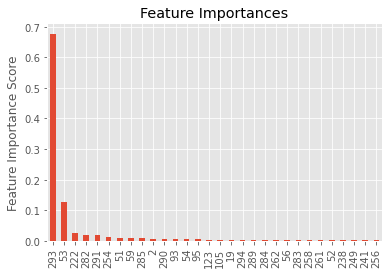

In [115]:
gbm0 = GradientBoostingClassifier(random_state=10)
gboost_conf_mat, gboost_pred_prob = modelfit_gradientboost(gbm0, X_train, y_train, X_test, y_test, performCV=True)

{FPR} == Oportunidad de conversión perdida ==> 0.06
{TPR} == Savings en la inverisón ==> 0.82
{Accuracy} == Sanity total ==> 0.88


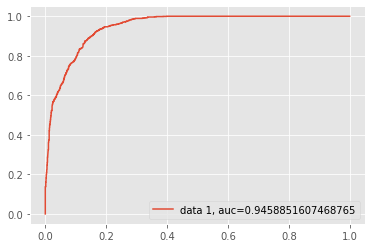

In [279]:
gboost_metrics = assess_model(gboost_conf_mat)
render_metrics(gboost_metrics, gboost_pred_prob, y_test)

<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Benchmark definidos!</strong> 
</div>

#### Parameter tuning

In [61]:
def grid_gboost(grid, score):
    gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = grid, scoring=score,n_jobs=-1,  cv=5)

    print('************************************** Grid Search **************************************')
    start_time = time.time()
    gsearch1.fit(X_train,y_train)
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*****************************************************************************************')
    gboost_conf_mat_1, gboost_pred_prob_1, gboost_pred_1 = render_gridsearch(gsearch1, X_test, y_test)
    gboost_metrics_1 = assess_model(gboost_conf_mat_1)
    render_metrics(gboost_metrics_1, gboost_pred_prob_1, y_test)

In [62]:
def make_grid(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, random_state, 
              n_iter_no_change, scoring):
    grid =    {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth,
               'max_features': max_features,
               'subsample': subsample,
               'random_state': random_state,
               'n_iter_no_change': n_iter_no_change}
    grid_gboost(grid, scoring)

In [63]:
def define_grid(start, stop, num, learning, minsplit, minleaf, maxdepth, maxfeat, subsample, random, earlystop, scoring): 

    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
    learning_rate = learning
    min_samples_split= minsplit
    min_samples_leaf= minleaf
    max_depth= maxdepth
    max_features= maxfeat
    subsample= subsample
    random_state= random
    n_iter_no_change = earlystop
    scoring = scoring
    
    make_grid(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, random_state, 
                n_iter_no_change, scoring)

accuracy
************************************** Grid Search **************************************
Time consumption: --- 244.72882461547852 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.947410
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


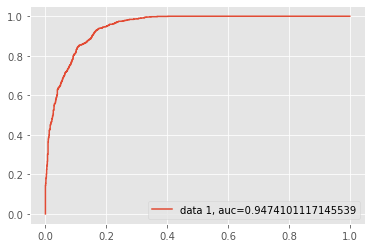

In [68]:
define_grid(100,500,50,[0.1],[500],[50],[8],['sqrt'],[0.8],[10],[5],'accuracy')

************************************** Grid Search **************************************
Time consumption: --- 45.231714725494385 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.947410
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


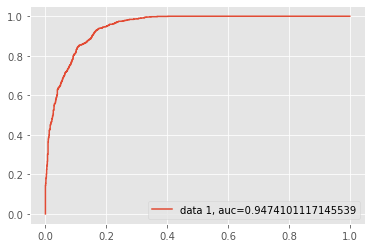

In [67]:
param_gboost1 = {'n_estimators':range(100,500,50)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5), param_grid = param_gboost1, scoring='accuracy',n_jobs=-1,  cv=5)

print('************************************** Grid Search **************************************')
start_time = time.time()
gsearch1.fit(X_train,y_train)
print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
print('*****************************************************************************************')
gboost_conf_mat_1, gboost_pred_prob_1, gboost_pred_1 = render_gridsearch(gsearch1, X_test, y_test)
gboost_metrics_1 = assess_model(gboost_conf_mat_1)
render_metrics(gboost_metrics_1, gboost_pred_prob_1, y_test)

<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>GridSearch is more time consumering!</strong> 4.5X times!
</div>

In [209]:
def over_under_fit(dfs, array):
    param= []
    for i in range(0, len(array)):
        param.append('param_'+array[i]) 
        df = dfs[['mean_fit_time', 'mean_train_score', 'mean_test_score', param[i]]]
        df['diff'] = df['mean_test_score']- df['mean_train_score']
        fig = make_subplots(rows=1, cols=3, shared_yaxes=False, 
                           subplot_titles=("Train Test score","Score Diff", "Feat time"))
        if (len(array))>1:
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_train_score'], mode="markers"),
                  1, 1)
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_test_score'], mode="markers"),
                  1, 1)
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['diff'], mode="markers"), 
                  1, 2)
            fig.add_trace(go.Bar(x=df[param[i]], y=df['mean_fit_time']),
                  1, 3)
            fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
            fig.show()  
        
        else:
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_train_score']),
                  1, 1)
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_test_score']),
                  1, 1)
            fig.add_trace(go.Bar(x=df[param[i]], y=df['diff']), 
                  1, 2)
            fig.add_trace(go.Bar(x=df[param[i]], y=df['mean_fit_time']),
                  1, 3)
            fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
            fig.show()  

In [139]:
def final_grid_gboost(gsearch1, scoring):
    print('************************************** Grid Search **************************************')
    start_time = time.time()
    gsearch1.fit(X_train,y_train)
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*****************************************************************************************')
    gboost_conf_mat_1, gboost_pred_prob_1, gboost_pred_1 = render_gridsearch(gsearch1, X_test, y_test)
    gboost_metrics_1 = assess_model(gboost_conf_mat_1)
    print(gsearch1.best_params_)
    render_metrics(gboost_metrics_1, gboost_pred_prob_1, y_test)  
    df = pd.DataFrame(gsearch1.cv_results_)
    return df

************************************** Grid Search **************************************
Time consumption: --- 41.580363273620605 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.947410
{'n_estimators': 200}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


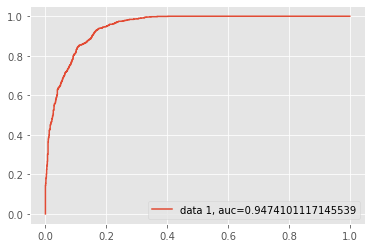

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [196]:
param_gboost1 = {'n_estimators':range(100,500,50)}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['n_estimators'])


************************************** Grid Search **************************************
Time consumption: --- 54.05273485183716 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8799
AUC Score (Train): 0.947897
{'learning_rate': 0.0778}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


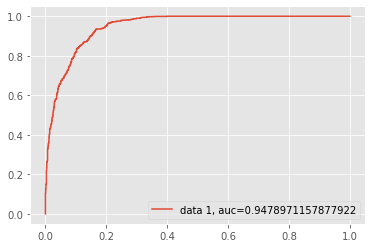

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [197]:
param_gboost1 = {'learning_rate':[round(float(x), 4) for x in np.linspace(0.0001, 0.1, num = 10)]}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5, n_estimators = 200), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['learning_rate'])


************************************** Grid Search **************************************
Time consumption: --- 12.261978387832642 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.947410
{'learning_rate': 0.1}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


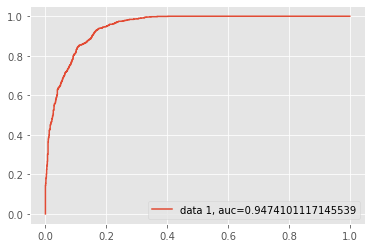

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [198]:
param_gboost1 = {'learning_rate':[round(float(x), 4) for x in np.linspace(0.1, 3, num = 10)]}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5, n_estimators = 200), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['learning_rate'])


************************************** Grid Search **************************************
Time consumption: --- 31.925697803497314 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.947410
{'max_depth': 8}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


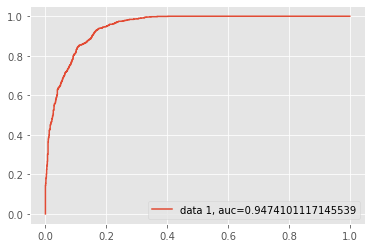

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [205]:
param_gboost1 = {'max_depth':[int(x) for x in np.linspace(3, 8, num = 5)]}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( learning_rate = 0.1, min_samples_split=500,min_samples_leaf=50,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5, n_estimators = 200), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth'])

************************************** Grid Search **************************************
Time consumption: --- 1.8451499938964844 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.6813
AUC Score (Train): 0.753657
{'max_depth': 8}
{FPR} == Oportunidad de conversión perdida ==> 0.60
{TPR} == Savings en la inverisón ==> 0.96
{Accuracy} == Sanity total ==> 0.68


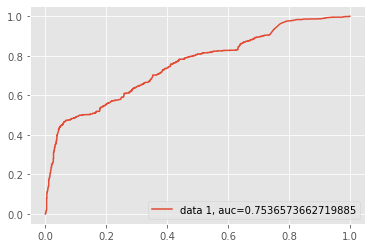

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
param_gboost1 = {'max_depth':[int(x) for x in np.linspace(3, 8, num = 5)]}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( learning_rate = 2.5, min_samples_split=500,min_samples_leaf=50,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5, n_estimators = 200), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth'])


<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Equilibrio!</strong> Jugando con learning rate, n_estimators o min split para ver como se puede reducir el overfit
</div>

************************************** Grid Search **************************************
Time consumption: --- 174.84603905677795 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.947410
{'max_depth': 8, 'n_estimators': 200}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


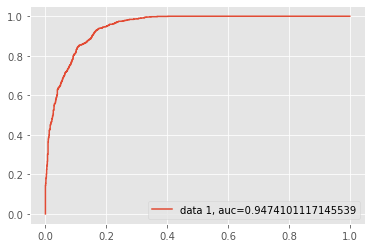

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [210]:
param_gboost1 = {'max_depth':[int(x) for x in np.linspace(3, 8, num = 5)],
                'n_estimators':range(100,500,50)}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( learning_rate = 0.1, min_samples_split=500,min_samples_leaf=50,max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth', 'n_estimators'])


<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Elección!</strong> Ningún caso sobrepasa el -0.05
</div>

In [202]:
u_ov['diff'] = round(u_ov['mean_test_score'] - u_ov['mean_train_score'], 4)
u_ov['over'] = 0
u_ov.loc[u_ov['diff'] < 0, "over" ] = 1
u_ov['diff'] = abs(round(u_ov['mean_test_score'] - u_ov['mean_train_score'], 4))

In [203]:
fig = px.scatter(u_ov, x="param_n_estimators", y="param_max_depth", color="over",
                 size='diff')
fig.show()

************************************** Grid Search **************************************
Time consumption: --- 88.3549416065216 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8799
AUC Score (Train): 0.947612
{'max_features': 'sqrt', 'min_samples_split': 600}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


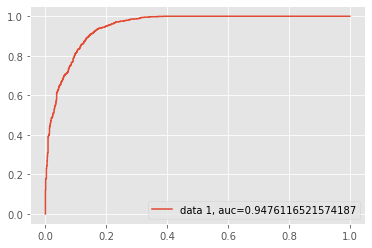

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [214]:
param_gboost1 = {'min_samples_split':[int(x) for x in np.linspace(100, 800, num = 8)],
                'max_features':['sqrt', 'log2']}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( n_estimators = 200, max_depth = 8, learning_rate = 0.1 ,min_samples_leaf=50,
                                                               subsample=0.8,random_state=10, n_iter_no_change = 5), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['min_samples_split', 'max_features'])


************************************** Grid Search **************************************
Time consumption: --- 1411.942553281784 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8807
AUC Score (Train): 0.948606
{'max_depth': 15, 'min_samples_split': 800, 'n_estimators': 200}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.85
{Accuracy} == Sanity total ==> 0.88


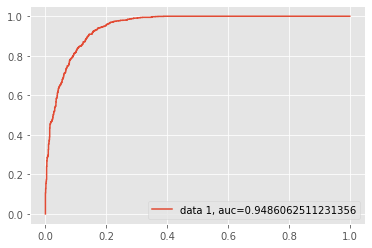

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [215]:

param_gboost1 = {'max_depth':[int(x) for x in np.linspace(3, 15, num = 5)],
                 'n_estimators':range(100,500,50), 
                 'min_samples_split':[int(x) for x in np.linspace(100, 800, num = 8)]}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( learning_rate = 0.1, min_samples_leaf=50, max_features='sqrt'
                                                               ,subsample=0.8,random_state=10, n_iter_no_change = 5), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth', 'n_estimators', 'min_samples_split'])


In [218]:
[float(x) for x in np.linspace(0.6, 0.9, num = 3)]

[0.6, 0.75, 0.9]

************************************** Grid Search **************************************
Time consumption: --- 18.294159173965454 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8772
AUC Score (Train): 0.947604
{'subsample': 0.9}
{FPR} == Oportunidad de conversión perdida ==> 0.09
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


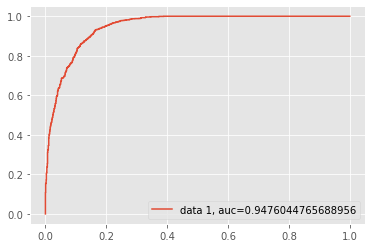

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [219]:
param_gboost1 = {'subsample':[float(x) for x in np.linspace(0.6, 0.9, num = 3)]}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( max_depth = 15, min_samples_split = 800, n_estimators = 200, learning_rate = 0.1, min_samples_leaf=50, max_features='sqrt'
                                                               ,random_state=10, n_iter_no_change = 5), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['subsample'])


************************************** Grid Search **************************************
Time consumption: --- 45.36442518234253 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8811
AUC Score (Train): 0.948914
{'learning_rate': 0.2078}
{FPR} == Oportunidad de conversión perdida ==> 0.09
{TPR} == Savings en la inverisón ==> 0.85
{Accuracy} == Sanity total ==> 0.88


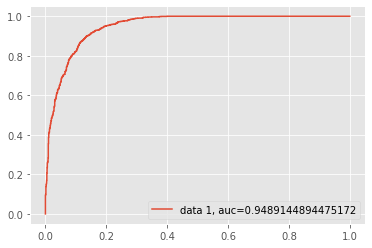

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [220]:
param_gboost1 = {'learning_rate':[round(float(x), 4) for x in np.linspace(0.001, 3, num = 30)]}
scoring = 'accuracy'
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier( subsample = 0.9,  max_depth = 15, min_samples_split = 800, n_estimators = 200,  min_samples_leaf=50, max_features='sqrt'
                                                               ,random_state=10, n_iter_no_change = 5), param_grid = param_gboost1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['learning_rate'])

### XGBoost

#### Baseline

In [121]:
def modelfit_xgboost(alg, X_train, X_test, y_train, y_test, val, useTrainCV=True, cv_folds=5, 
                                                 early_stopping_rounds=50, printFeatureImportance = True):
    
    print('************************************** X Gradient Boost **************************************')
    start_time = time.time()
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
            metrics=val, early_stopping_rounds=50)
        alg.set_params(n_estimators=cvresult.shape[0])
        print('Total number of trees: '+ str(cvresult.shape[0]))
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (mean(cvresult['test-'+val+'-mean']),std(cvresult['test-'+val+'-mean']),min(cvresult['test-'+val+'-mean']),max(cvresult['test-'+val+'-mean'])))
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric=val)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
    cf_matrix = confusion_matrix(y_test, dtrain_predictions)
    print(cf_matrix)
    
    
    
    if printFeatureImportance:
        feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
        print('Total number of features: '+ str(len(feat_imp)))
        feat_imp = feat_imp[:30]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*********************************************************************************************')
    
    
    
    return cf_matrix, dtrain_predprob, cvresult

(10125, 295)
************************************** X Gradient Boost **************************************
Total number of trees: 220
CV Score : Mean - 0.9388586 | Std - 0.008224445 | Min - 0.876865 | Max - 0.9447358

Model Report
Accuracy : 0.8839
AUC Score (Train): 0.946835
[[1041  212]
 [  82 1197]]
Total number of features: 156


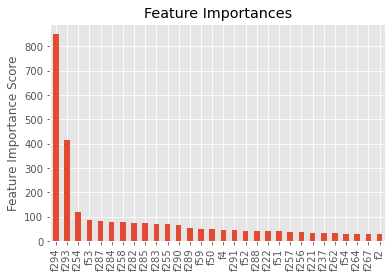

Time consumption: --- 87.6658124923706 seconds ---
*********************************************************************************************
{FPR} == Oportunidad de conversión perdida ==> 0.06
{TPR} == Savings en la inverisón ==> 0.83
{Accuracy} == Sanity total ==> 0.88


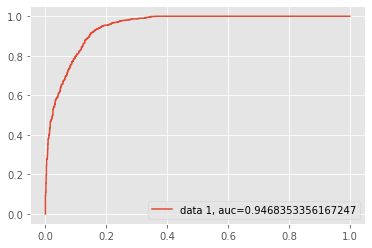

In [122]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

print(X_train.shape)
xgb_cf_matrix, xgb_y_predprob, xgb_cvresult = modelfit_xgboost(xgb1, X_train, X_test, y_train, y_test, 'map')
xgboost_metrics = assess_model(xgb_cf_matrix)
render_metrics(xgboost_metrics, xgb_y_predprob, y_test)

(10125, 295)
************************************** X Gradient Boost **************************************
Total number of trees: 220
CV Score : Mean - 0.9458519 | Std - 0.006484846 | Min - 0.9099892 | Max - 0.9509634

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.948964
[[1067  209]
 [  97 1159]]
Total number of features: 166


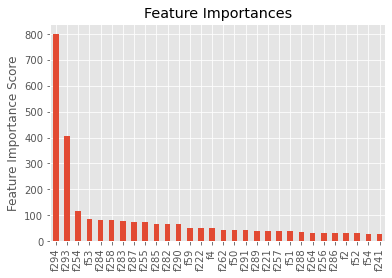

Time consumption: --- 91.81441402435303 seconds ---
*********************************************************************************************
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


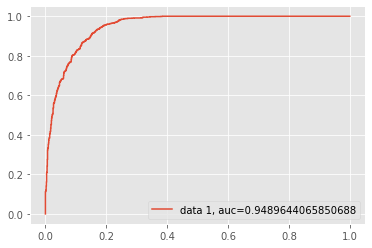

In [252]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

print(X_train.shape)
xgb_cf_matrix, xgb_y_predprob, xgb_cvresult = modelfit_xgboost(xgb1, X_train, X_test, y_train, y_test, 'auc')
xgboost_metrics = assess_model(xgb_cf_matrix)
render_metrics(xgboost_metrics, xgb_y_predprob, y_test)

<div class="alert_info">
  <span class="closebtn" onclick=""></span>
  <strong>Features!</strong> Por que salen 166 features de 295 que hay?
</div>

<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Metrics!</strong> Por el earlystopping
</div>

<div class="alert_info">
  <span class="closebtn" onclick=""></span>
  <strong>Metrics!</strong> Solo me deja LogLoss, error y auc - accuracy etc no estaría mál disponer de una lista de scores por modelo
</div>

(10125, 295)
************************************** X Gradient Boost **************************************
Total number of trees: 220
CV Score : Mean - 0.2969663 | Std - 0.05476339 | Min - 0.2698116 | Max - 0.640107

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.948964
[[1067  209]
 [  97 1159]]
Total number of features: 166


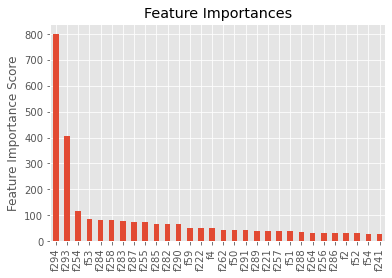

Time consumption: --- 84.98423886299133 seconds ---
*********************************************************************************************
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


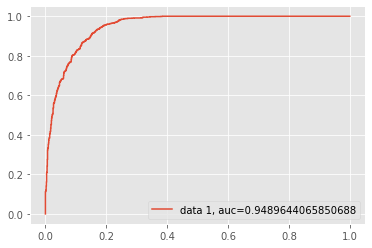

In [260]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

print(X_train.shape)
xgb_cf_matrix, xgb_y_predprob = modelfit_xgboost(xgb1, X_train, X_test, y_train, y_test, 'logloss')
xgboost_metrics = assess_model(xgb_cf_matrix)
render_metrics(xgboost_metrics, xgb_y_predprob, y_test)

(10125, 295)
************************************** X Gradient Boost **************************************
Total number of trees: 100
CV Score : Mean - 0.3242317 | Std - 0.07205117 | Min - 0.277164 | Max - 0.640771

Model Report
Accuracy : 0.8724
AUC Score (Train): 0.944338
[[1012  241]
 [  82 1197]]
Total number of features: 123


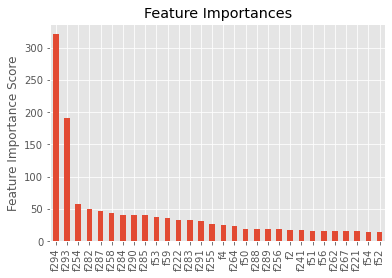

Time consumption: --- 39.74893522262573 seconds ---
*********************************************************************************************
{FPR} == Oportunidad de conversión perdida ==> 0.06
{TPR} == Savings en la inverisón ==> 0.81
{Accuracy} == Sanity total ==> 0.87


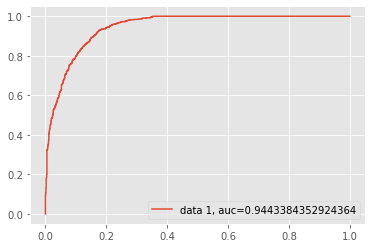

In [117]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

print(X_train.shape)
xgb_cf_matrix, xgb_y_predprob = modelfit_xgboost(xgb1, X_train, X_test, y_train, y_test, 'logloss')
xgboost_metrics = assess_model(xgb_cf_matrix)
render_metrics(xgboost_metrics, xgb_y_predprob, y_test)

<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Benchmark definidos!</strong> 
</div>

#### Parameter tuning

In [ ]:
def over_under_fit_xgboost(dfs, array):
    param= []
    for i in range(0, len(array)):
        param.append('param_'+array[i]) 
        df = dfs[['mean_fit_time', 'mean_train_score', 'mean_test_score', param[i]]]
        df['diff'] = df['mean_test_score']- df['mean_train_score']
        fig = make_subplots(rows=1, cols=3, shared_yaxes=False, 
                           subplot_titles=("Train Test score","Score Diff", "Feat time"))
        if (len(array))>1:
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_train_score'], mode="markers"),
                  1, 1)
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_test_score'], mode="markers"),
                  1, 1)
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['diff'], mode="markers"), 
                  1, 2)
            fig.add_trace(go.Bar(x=df[param[i]], y=df['mean_fit_time']),
                  1, 3)
            fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
            fig.show()  
        
        else:
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_train_score']),
                  1, 1)
            fig.add_trace(go.Scatter(x=df[param[i]], y=df['mean_test_score']),
                  1, 1)
            fig.add_trace(go.Bar(x=df[param[i]], y=df['diff']), 
                  1, 2)
            fig.add_trace(go.Bar(x=df[param[i]], y=df['mean_fit_time']),
                  1, 3)
            fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
            fig.show()  

(10125, 295)
************************************** X Gradient Boost **************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.948964
[[1067  209]
 [  97 1159]]
Total number of features: 166


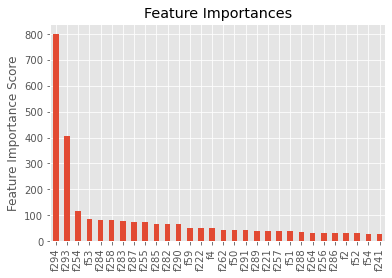

Time consumption: --- 12.868610382080078 seconds ---
*********************************************************************************************
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


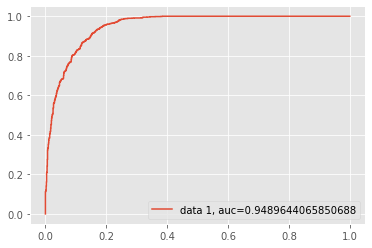

In [262]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

print(X_train.shape)
xgb_cf_matrix, xgb_y_predprob = modelfit_xgboost(xgb1, X_train, X_test, y_train, y_test,  'logloss', useTrainCV=False)
xgboost_metrics = assess_model(xgb_cf_matrix)
render_metrics(xgboost_metrics, xgb_y_predprob, y_test)

In [300]:
def final_grid_xgboost2(gsearch1, scoring):
    print('************************************** Grid Search **************************************')
    start_time = time.time()
    eval_set = [(X_test, y_test)]
    gsearch1.fit(X_train, y_train, early_stopping_rounds=5, eval_metric="logloss", eval_set=eval_set)
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*****************************************************************************************')
    gboost_conf_mat_1, gboost_pred_prob_1, gboost_pred_1 = render_gridsearch(gsearch1, X_test, y_test)
    gboost_metrics_1 = assess_model(gboost_conf_mat_1)
    print(gsearch1.best_params_)
    render_metrics(gboost_metrics_1, gboost_pred_prob_1, y_test)  
    df = pd.DataFrame(gsearch1.cv_results_)
    return df

In [278]:
def final_grid_xgboost(gsearch1, scoring):
    print('************************************** Grid Search **************************************')
    start_time = time.time()
    gsearch1.fit(X_train,y_train, eval_metric=scoring, early_stopping_rounds = 5)
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*****************************************************************************************')
    gboost_conf_mat_1, gboost_pred_prob_1, gboost_pred_1 = render_gridsearch(gsearch1, X_test, y_test)
    gboost_metrics_1 = assess_model(gboost_conf_mat_1)
    print(gsearch1.best_params_)
    render_metrics(gboost_metrics_1, gboost_pred_prob_1, y_test)  
    df = pd.DataFrame(gsearch1.cv_results_)
    return df

************************************** Grid Search **************************************
[13:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time consumption: --- 288.72349429130554 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8791
AUC Score (Train): 0.948964
{'max_depth': 5}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


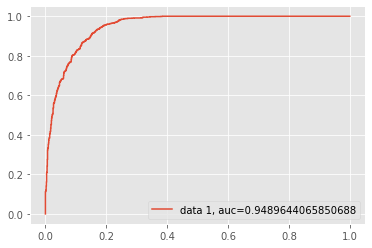

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [266]:
param_xgboost1 = {
 'max_depth':range(3,10,2)
}

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)


gsearch1 = GridSearchCV(estimator = xgb1, 
 param_grid = param_xgboost1, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth', 'min_child_weight'])

************************************** Grid Search **************************************
Time consumption: --- 758.3492546081543 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8803
AUC Score (Train): 0.948292
{'max_depth': 5, 'min_child_weight': 5}
{FPR} == Oportunidad de conversión perdida ==> 0.08
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.88


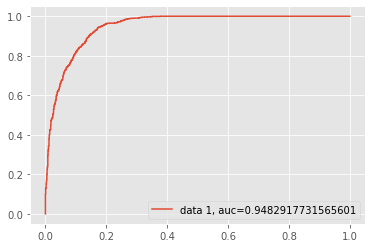

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [275]:
param_xgboost1 = {
 'max_depth':range(3,10,2), 
 'min_child_weight':[4,5,6] 
    
}

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

scoring = 'logloss'
gsearch1 = GridSearchCV(estimator = xgb1, 
 param_grid = param_xgboost1, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score = True)
u_ov = final_grid_xgboost(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth', 'min_child_weight'])

************************************** Grid Search **************************************
[0]	validation_0-logloss:0.64195
[1]	validation_0-logloss:0.59995
[2]	validation_0-logloss:0.58712
[3]	validation_0-logloss:0.55401
[4]	validation_0-logloss:0.52757
[5]	validation_0-logloss:0.50496
[6]	validation_0-logloss:0.48555
[7]	validation_0-logloss:0.46703
[8]	validation_0-logloss:0.45094
[9]	validation_0-logloss:0.43688
[10]	validation_0-logloss:0.42499
[11]	validation_0-logloss:0.42037
[12]	validation_0-logloss:0.41019
[13]	validation_0-logloss:0.40120
[14]	validation_0-logloss:0.39263
[15]	validation_0-logloss:0.38563
[16]	validation_0-logloss:0.37933
[17]	validation_0-logloss:0.37690
[18]	validation_0-logloss:0.37060
[19]	validation_0-logloss:0.36508
[20]	validation_0-logloss:0.36055
[21]	validation_0-logloss:0.35802
[22]	validation_0-logloss:0.35414
[23]	validation_0-logloss:0.35023
[24]	validation_0-logloss:0.34701
[25]	validation_0-logloss:0.34393
[26]	validation_0-logloss:0.34060
[2

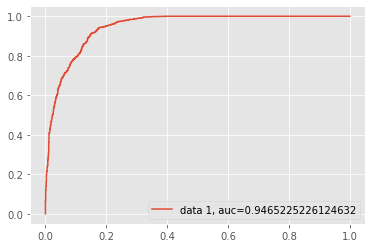

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [296]:
#EarlyStopping de 5
param_xgboost1 = {
 'max_depth':range(3,10,2), 
 'min_child_weight':[4,5,6] 
    
}

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

scoring = 'logloss'
gsearch1 = GridSearchCV(estimator = xgb1, 
                            param_grid = param_xgboost1, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score = True)
u_ov = final_grid_xgboost2(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth', 'min_child_weight'])

************************************** Grid Search **************************************
[0]	validation_0-logloss:0.64003
[1]	validation_0-logloss:0.59478
[2]	validation_0-logloss:0.57845
[3]	validation_0-logloss:0.54367
[4]	validation_0-logloss:0.51463
[5]	validation_0-logloss:0.49098
[6]	validation_0-logloss:0.47050
[7]	validation_0-logloss:0.45097
[8]	validation_0-logloss:0.43374
[9]	validation_0-logloss:0.41896
[10]	validation_0-logloss:0.40611
[11]	validation_0-logloss:0.39962
[12]	validation_0-logloss:0.38875
[13]	validation_0-logloss:0.37940
[14]	validation_0-logloss:0.37087
[15]	validation_0-logloss:0.36336
[16]	validation_0-logloss:0.35658
[17]	validation_0-logloss:0.35434
[18]	validation_0-logloss:0.34841
[19]	validation_0-logloss:0.34341
[20]	validation_0-logloss:0.33892
[21]	validation_0-logloss:0.33678
[22]	validation_0-logloss:0.33249
[23]	validation_0-logloss:0.32866
[24]	validation_0-logloss:0.32548
[25]	validation_0-logloss:0.32260
[26]	validation_0-logloss:0.31984
[2

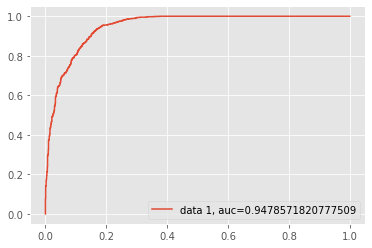

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [294]:
#EarlyStopping de 10
param_xgboost1 = {
 'max_depth':range(3,10,2), 
 'min_child_weight':[4,5,6] 
    
}

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

scoring = 'logloss'
gsearch1 = GridSearchCV(estimator = xgb1, 
                            param_grid = param_xgboost1, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score = True)
u_ov = final_grid_xgboost2(gsearch1, scoring)
over_under_fit(u_ov, ['max_depth', 'min_child_weight'])

************************************** Grid Search **************************************
[0]	validation_0-logloss:0.64003
[1]	validation_0-logloss:0.59478
[2]	validation_0-logloss:0.57845
[3]	validation_0-logloss:0.54367
[4]	validation_0-logloss:0.51463
[5]	validation_0-logloss:0.49098
[6]	validation_0-logloss:0.47050
[7]	validation_0-logloss:0.45097
[8]	validation_0-logloss:0.43374
[9]	validation_0-logloss:0.41896
[10]	validation_0-logloss:0.40611
[11]	validation_0-logloss:0.39962
[12]	validation_0-logloss:0.38875
[13]	validation_0-logloss:0.37940
[14]	validation_0-logloss:0.37087
[15]	validation_0-logloss:0.36336
[16]	validation_0-logloss:0.35658
[17]	validation_0-logloss:0.35434
[18]	validation_0-logloss:0.34841
[19]	validation_0-logloss:0.34341
[20]	validation_0-logloss:0.33892
[21]	validation_0-logloss:0.33678
[22]	validation_0-logloss:0.33249
[23]	validation_0-logloss:0.32866
[24]	validation_0-logloss:0.32548
[25]	validation_0-logloss:0.32260
[26]	validation_0-logloss:0.31984
[2

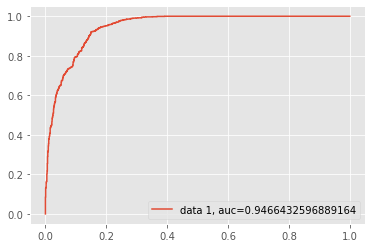

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [301]:
param_xgboost1 = {
 'gamma':[i/10.0 for i in range(0,5)]
    
}

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=220,
    min_child_weight=5,
    max_depth = 5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    use_label_encoder =False,
    seed=27)

scoring = 'logloss'
gsearch1 = GridSearchCV(estimator = xgb1, 
                            param_grid = param_xgboost1, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score = True)
u_ov = final_grid_xgboost2(gsearch1, scoring)
over_under_fit(u_ov, ['gamma'])

### Random Forest

#### Baseline

In [314]:
def modelfit_rf(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    print('************************************** Random Forest **************************************')
    start_time = time.time()
        
    alg.fit(X_train, y_train)
        
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
    cf_matrix = confusion_matrix(y_test, dtrain_predictions)
    print(cf_matrix)
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        print('Total number of features: '+str(len(pd.Series(alg.feature_importances_))))
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)[:30]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*********************************************************************************************')
    return cf_matrix, dtrain_predprob, dtrain_predictions

************************************** Random Forest **************************************

Model Report
Accuracy : 0.8661
AUC Score (Train): 0.936904
[[1069  207]
 [ 132 1124]]
CV Score : Mean - 0.9335138 | Std - 0.006918412 | Min - 0.9232956 | Max - 0.9445008
Total number of features: 295


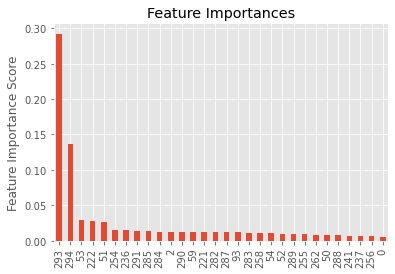

Time consumption: --- 22.095452308654785 seconds ---
*********************************************************************************************
{FPR} == Oportunidad de conversión perdida ==> 0.11
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.87


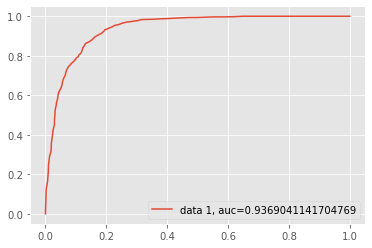

In [315]:
rf = RandomForestClassifier(random_state=10)
rf_conf_mat, rf_pred_prob, rf_pred = modelfit_rf(rf, X_train, y_train, X_test, y_test)
rf_metrics = assess_model(rf_conf_mat)
render_metrics(rf_metrics, rf_pred_prob, y_test)

In [318]:
from sklearn.metrics import precision_score, recall_score
recall = recall_score(y_test, rf_pred)

In [319]:
recall

0.8949044585987261

In [320]:
rf_metrics[0]

0.8377742946708464

<div class="alert_info">
  <span class="closebtn" onclick=""></span>
  <strong>Preguntas!</strong> Me debería de dar lo mismo, no?
</div>

In [309]:
param_rf1 = {'n_estimators':[int(x) for x in np.linspace(10, 500, num = 10)]}
scoring = 'accuracy'

In [311]:
estimator = RandomForestClassifier( 
                                    criterion= 'gini',
                                    max_features='sqrt',
                                    #n_estimators = 200,
                                    min_samples_leaf = 50,
                                    max_depth = None,
                                    n_jobs = -1,
                                    random_state=10
                                    )

************************************** Grid Search **************************************
Time consumption: --- 80.59403252601624 seconds ---
*****************************************************************************************

Model Report
Accuracy : 0.8361
AUC Score (Train): 0.922916
{'n_estimators': 500}
{FPR} == Oportunidad de conversión perdida ==> 0.17
{TPR} == Savings en la inverisón ==> 0.84
{Accuracy} == Sanity total ==> 0.84


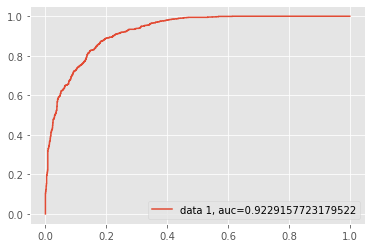

C:\ProgramData\Anaconda3\envs\P_GDatabase\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [313]:
gsearch1 = GridSearchCV(estimator = estimator, param_grid = param_rf1, scoring=scoring,n_jobs=-1,  cv=5, return_train_score = True)
u_ov = final_grid_gboost(gsearch1, scoring)
over_under_fit(u_ov, ['n_estimators'])

<div class="alert_info">
  <span class="closebtn" onclick=""></span>
  <strong>Preguntas!</strong> min impurity decrease - como se juega con ese valor? Sería el early stopping no?
</div>
<br>
<div class="alert_info">
  <span class="closebtn" onclick=""></span>
  <strong>Preguntas!</strong> Warm start - como usar ese valor?
</div>
<br>

### SVM

#### Baseline

In [326]:
def modelfit_svm(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    print('************************************** SVM **************************************')
    start_time = time.time()
        
    alg.fit(X_train, y_train)
        
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
    cf_matrix = confusion_matrix(y_test, dtrain_predictions)
    print(cf_matrix)
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    print('Time consumption: --- %s seconds ---' % (time.time() - start_time))
    print('*********************************************************************************************')
    return cf_matrix, dtrain_predprob, dtrain_predictions

************************************** SVM **************************************

Model Report
Accuracy : 0.7784
AUC Score (Train): 0.856838
[[976 300]
 [261 995]]
CV Score : Mean - 0.8461388 | Std - 0.008191783 | Min - 0.8370687 | Max - 0.8573409
Time consumption: --- 715.5820925235748 seconds ---
*********************************************************************************************
{FPR} == Oportunidad de conversión perdida ==> 0.21
{TPR} == Savings en la inverisón ==> 0.76
{Accuracy} == Sanity total ==> 0.78


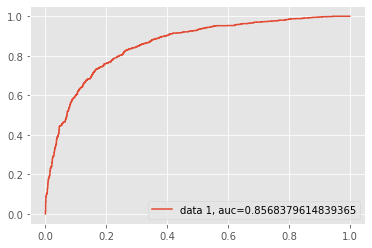

In [327]:
svm = SVC(random_state=10, probability = True)
svm_conf_mat, svm_pred_prob, svm_pred = modelfit_svm(svm, X_train, y_train, X_test, y_test)
svm_metrics = assess_model(svm_conf_mat)
render_metrics(svm_metrics, svm_pred_prob, y_test)

<div class="images">
  <span class="closebtn" onclick=""></span>
  <strong>Learning!</strong> En SVM, obtener las probabilidades requiere mucho más tiempo. 
</div>
<br>

In [ ]:
start_time = time.time()    
        
alg.fit(X_train, y_train)

dtrain_predictions = alg.predict(X_test)
dtrain_predprob = alg.predict_proba(X_test)[:,1]

if performCV:
    cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')

#Print model report:
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
cf_matrix = confusion_matrix(y_test, dtrain_predictions)
print(cf_matrix)
if performCV:
    print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

print('Time consumption: --- %s seconds ---' % (time.time() - start_time))

In [330]:
svm = SVC(random_state=10, probability = True)
start_time = time.time()            
svm.fit(X_train, y_train)
print('Time consumption: --- %s seconds ---' % (time.time() - start_time))

Time consumption: --- 154.4739112854004 seconds ---


In [331]:
svm = SVC(random_state=10, probability = False)
start_time = time.time()            
svm.fit(X_train, y_train)
print('Time consumption: --- %s seconds ---' % (time.time() - start_time))

Time consumption: --- 28.989946126937866 seconds ---


## Extras

Creo que el manejo de los árboles y su entendimiento puede equipararse a la regresión lineal. Como consecuencia incluyo código que puede ser ayuda para aquellos que estén interesados en profundizar con la estructura. No he encontrado mucho código al respecto!

Dispone de:
* Metodos para visualizar los arboles de forma distinta. 
* Metodos para obtener información del arbol: Hojas, splits, niveles  etc. 

In [36]:
# Instance of the decision tree classifier
tree_clf = tree.DecisionTreeClassifier()

# Fitting of the data
tree_clf.fit(X,y)

DecisionTreeClassifier()

In [37]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [38]:
print(tree.export_text(tree_clf))

|--- feature_293 <= 0.01
|   |--- class: 0.0
|--- feature_293 >  0.01
|   |--- feature_53 <= 0.50
|   |   |--- feature_222 <= 0.50
|   |   |   |--- feature_96 <= 0.50
|   |   |   |   |--- feature_244 <= 0.50
|   |   |   |   |   |--- feature_155 <= 0.50
|   |   |   |   |   |   |--- feature_251 <= 0.50
|   |   |   |   |   |   |   |--- feature_11 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_258 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_294 <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- feature_293 <= 0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- feature_293 >  0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- feature_294 >  0.00
|   |   |   |   |   |   |   |   |   |   |--- feature_291 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   

In [123]:
def get_leaf(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)] 
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        is_split_node = children_left[node_id] != children_right[node_id]

        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True
    return is_leaves

In [74]:
def get_node_depths(tree):

    def get_node_depths_(current_node, current_depth, l, r, depths):
        depths += [current_depth]
        if l[current_node] != -1 and r[current_node] != -1:
            get_node_depths_(l[current_node], current_depth + 1, l, r, depths)
            get_node_depths_(r[current_node], current_depth + 1, l, r, depths)

    depths = []
    get_node_depths_(0, 0, tree.children_left, tree.children_right, depths) 
    return np.array(depths)

In [124]:
depths = get_node_depths(tree_clf.tree_)
leafs = get_leaf(tree_clf)

In [126]:
tree_df = pd.DataFrame({'Samples': tree_clf.tree_.n_node_samples[:, ], 'Depth': depths[:, ], 'Leaf':  leafs[:, ]})
tree_df['node'] = tree_df.index
tree_df = tree_df.sort_values(by=['Depth'], ascending= True)
tree_df.head(10)

,Samples,Depth,Leaf,node
0,16657,0,False,0
1,3762,1,True,1
2,12895,1,False,2
3,8209,2,False,3
1800,4686,2,False,1800
4,2745,3,False,4
4266,264,3,False,4266
1801,4422,3,False,1801
187,5464,3,False,187
4267,207,4,False,4267


In [127]:
explore = tree_df.groupby([ 'Depth']).agg({'Samples':'sum'})
explore = explore.reset_index()
explore['Classified'] = (100*( explore['Samples'])/tree_df['Samples'][0]).round(2)
explore = explore.sort_values(by=['Depth'], ascending= True)

In [128]:
explore.head()

,Depth,Samples,Classified
0,0,16657,100.00
1,1,16657,100.00
2,2,12895,77.41
3,3,12895,77.41
4,4,12895,77.41


In [129]:
fig = px.line(explore, x='Depth', y=['Classified'], title= "% datos procesados por profundidad")
fig.show()

In [133]:
leaf_df = tree_df[tree_df['Leaf']==True]
leaf_df.head()

,Samples,Depth,Leaf,node
1,3762,1,True,1
186,1,4,True,186
4386,57,4,True,4386
4385,19,5,True,4385
185,1,6,True,185


In [134]:
leaf_df.shape 

(2194, 4)

In [146]:
explore = leaf_df.groupby([ 'Depth']).agg({'node':'nunique', 'Samples': [ 'min', 'max', 'sum', 'mean', 'median']})
explore = explore.reset_index()
explore = explore.sort_values(by=['Depth'], ascending= True)
explore.tail()

Depth    node Samples                     
         nunique     min max sum  mean median
67    70       5       1   8  14   2.8    2.0
68    71       3       2  25  36  12.0    9.0
69    72       5       1   7  11   2.2    1.0
70    73       1       7   7   7   7.0    7.0
71    74       2       1   4   5   2.5    2.5

In [150]:
explore.columns = explore.columns.get_level_values(0)

In [152]:
explore.columns = ['Depth', 'node count', 'min', 'max', 'sum', 'mean', 'median']

In [155]:
fig = px.line(explore, x='Depth', y=['max', 'sum', 'median', 'node count'], title= "% datos procesados por profundidad")
fig.show()

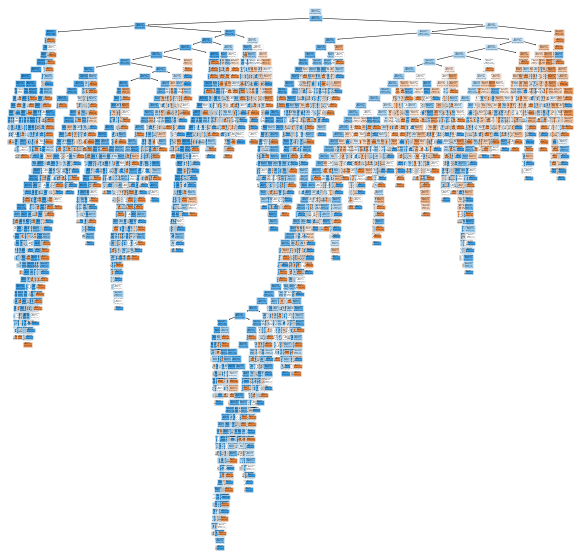

In [39]:
# See the decision tree generated
plt.figure(figsize=(10,10))
tree.plot_tree(tree_clf, filled=True)
plt.show()

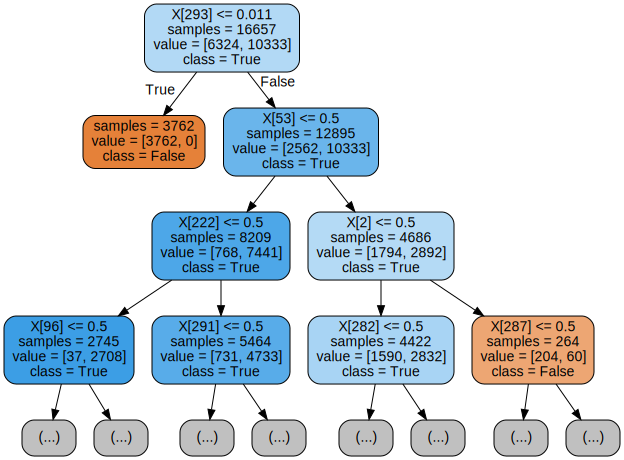

In [104]:
import graphviz
dot_data = tree.export_graphviz(tree_clf, 
                                class_names = ['False', 'True'],  
                                impurity=False,
                                filled=True,
                                max_depth = 3,
                                out_file =None,
                                rounded=True,) 
graph = graphviz.Source(dot_data) 
graph

In [47]:
graph.render('criteo')

'criteo.pdf'